# Interactive minimal working example
In this notebook you are going to run a single simulation, interactively, using the `simulation module` in `dlensalot/ana/config/examples/`, and our goal is to plot the lensing potential estimate.

# Header

In [1]:
import os
from os.path import join as opj
import numpy as np
import healpy as hp

import matplotlib.pyplot as plt

import lenscarf
from lenscarf.run import run

cond4mpi does not exists
could not setup healpix hack. reverting to standard healpy
MSC: using scarf with 2 OMP threads


# Choose analysis
## QE lensing reconstruction
The following cell selects an exisiting configuration file, initialises dlensalot for a QE lensing reconstruction job, and runs lensing reconstruction

In [2]:
fn = opj(os.path.dirname(os.path.abspath(lenscarf.__file__)),'ana/config/examples/mwe/conf_mwe_fullsky.py')
ana_mwe = run(config=fn, job_id='QE_lensrec', verbose=True).job
ana_mwe.run()

INFO:: 01-28 02:41:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/u2/s/sebibel/git/lenscarf/lenscarf/ana/config/examples/mwe/conf_mwe_fullsky.py
INFO:: 01-28 02:41:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 01-28 02:41:: lenscarf.lerepi.core.handler.log - store() Started
INFO:: 01-28 02:41:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /pscratch/sd/s/sebibel/dlensalot/lenscarf/sims_mwe/mwe_lminB200_my_first_dlensalot_analysis/conf_mwe_fullsky.py
INFO:: 01-28 02:41:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 01-28 02:41:: root.store - config file look the same. Resuming where I left off last time.
INFO:: 01-28 02:41:: root.store - Matching config file found. Resuming where I left off.
INFO:: 01-28 02:41:: lenscarf.lerepi.core.handler.log - store() Finished
INFO:: 01-28 02:41:: lenscarf.lerepi.core.handler.log - collect_jobs() Started
INFO:: 01-28 02:41:: lenscarf.lerepi.core.handler.log - co

## iterative lensing reconstruction
The following cell repeats above, for the iterative case

In [ ]:
fn = opj(os.path.dirname(os.path.abspath(lenscarf.__file__)),'ana/config/examples/mwe/conf_mwe_fullsky.py')
ana_mwe = run(config=fn, job_id='MAP_lensrec', verbose=True).job
ana_mwe.run()

INFO:: 01-28 05:12:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/u2/s/sebibel/git/lenscarf/lenscarf/ana/config/examples/mwe/conf_mwe_fullsky.py
INFO:: 01-28 05:12:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 01-28 05:12:: lenscarf.lerepi.core.handler.log - store() Started
INFO:: 01-28 05:12:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /pscratch/sd/s/sebibel/dlensalot/lenscarf/sims_mwe/mwe_lminB200_my_first_dlensalot_analysis/conf_mwe_fullsky.py
INFO:: 01-28 05:12:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 01-28 05:12:: root.store - config file look the same. Resuming where I left off last time.
INFO:: 01-28 05:12:: root.store - Matching config file found. Resuming where I left off.
INFO:: 01-28 05:12:: lenscarf.lerepi.core.handler.log - store() Finished
INFO:: 01-28 05:12:: lenscarf.lerepi.core.handler.log - collect_jobs() Started
INFO:: 01-28 05:12:: lenscarf.lerepi.core.handler.log - co

In [20]:
ana_mwe.lm_max_ivf

(4000, 4000)

# Check your results

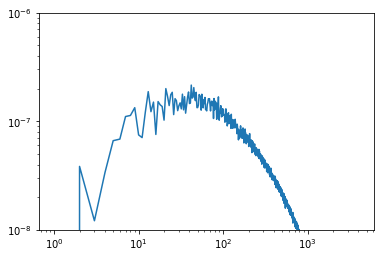

In [14]:
plm_QE = ana_mwe.get_plm(0)
plm_MAP = ana_mwe.get_plm_it(ana_mwe.itmax)

plt.plot(hp.alm2cl(plm_QE)*np.arange(0,4001,1)**4/(2*np.pi), label=r'C_L^{\phi^{\rm QE}\phi^{\rm QE}}')
plt.plot(hp.alm2cl(plm_MAP)*np.arange(0,4001,1)**4/(2*np.pi), label=r'C_L^{\phi^{\rm MAP}\phi^{\rm MAP}}')

plt.xlabel('Multipole, L')
plt.ylabel(r'$\left[L(L+1)\right]^2/(2*\pi)$')
plt.xscale('log')
plt.ylim(1e-8,1e-6)
plt.yscale('log')

# Other
## Check configuration
Let us look into the configuration file

In [3]:
print(ana_mwe.dlensalot_model.__str__())

## And how does the simulation data look like?

In [4]:
hp.mollview(ana_mwe.sims.get_sim_pmap(0)[0], title='E map')